# Exercise 3

## Imports

In [26]:
import time
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

## Data loading

In [27]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [28]:
ag_news_train_df.shape

(120000, 3)

In [29]:
ag_news_test_df.shape

(7600, 3)

In [30]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [31]:
amazon_reviews_df.shape

(17340, 4)

In [32]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [33]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

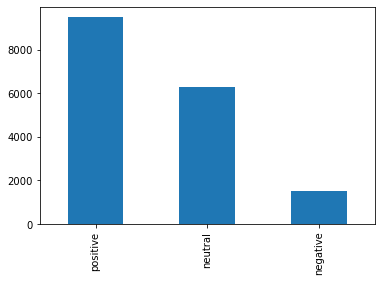

In [34]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

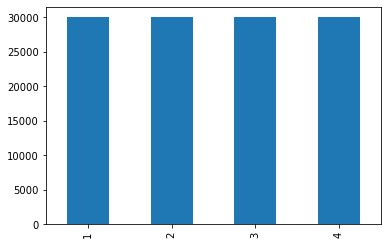

In [35]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

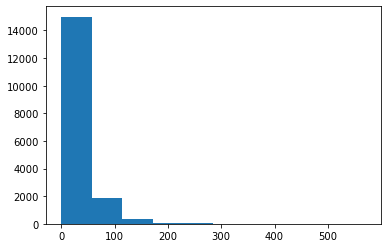

In [36]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

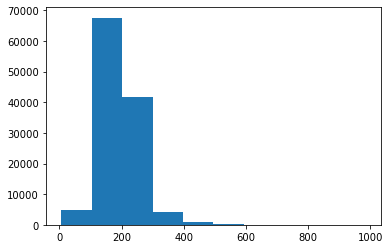

In [37]:
plt.hist(ag_news_train_df.Description.str.len())

In [38]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [39]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [40]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [41]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [53]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [42]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [43]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [44]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [55]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [57]:
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)

In [48]:
bigram_vectorizer.get_feature_names()

['a',
 'a bit',
 'a bunch',
 'a dependable',
 'a fantastic',
 'a faster',
 'a few',
 'a flimsy',
 'a friend',
 'a gift',
 'a good',
 'a great',
 'a little',
 'a lot',
 'a month',
 'a pretty',
 'a rechargeable',
 'a solid',
 'a sweet',
 'a tad',
 'a very',
 'a waste',
 'a well',
 'aa',
 'aa batteries',
 'aa battery',
 'aa only',
 'aaa',
 'aaa batteries',
 'aaa battery',
 'aaaaa',
 'aaaaaaaaaaaahhhh',
 'aaaaaaaaaaaahhhh hear',
 'aaron',
 'aaron diehl',
 'aasdbvdb',
 'abd',
 'abd if',
 'abilities',
 'abilities after',
 'abilities but',
 'abilities over',
 'ability',
 'ability and',
 'ability cause',
 'ability it',
 'ability on',
 'ability to',
 'ability with',
 'abillity',
 'abillity yet',
 'abit',
 'abit better',
 'abit more',
 'abit of',
 'able',
 'able to',
 'about',
 'about accuracy',
 'about activating',
 'about all',
 'about almost',
 'about am',
 'about an',
 'about and',
 'about any',
 'about anywhere',
 'about as',
 'about away',
 'about background',
 'about bad',
 'about batteri

In [56]:
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)

## Training shallow models

Balanced accuracy score is used to macro average across classes.

### Shallow NN (One layer perceptron)

In [60]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score

#### Reviews dataset

In [69]:
available_activations = ['relu', 'logistic']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_tr, y_train_reviews)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


study = optuna.create_study(direction='minimize')
# optuna.logging.set_verbosity(optuna.logging.DEBUG)
study.optimize(objective, n_trials=5,show_progress_bar=True)

study.best_params

[I 2023-02-03 22:28:36,108] A new study created in memory with name: no-name-105b53d0-0f0c-415b-8eb9-516e62b80a22
D:\Anaconda\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Trying: 65, 0.0005410614960283604, relu, lbfgs


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[I 2023-02-03 22:28:58,572] Trial 0 finished with value: 0.556164019038031 and parameters: {'size_of_hidden_layer': 65, 'alpha': 0.0005410614960283604, 'activation': 'relu', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.556164019038031.
Trying: 56, 0.0005155343094109715, relu, adam
Iteration 1, loss = 0.81389798
Iteration 2, loss = 0.37695481
Iteration 3, loss = 0.18543595
Iteration 4, loss = 0.10036984
Iteration 5, loss = 0.06088123
Iteration 6, loss = 0.04059136
Iteration 7, loss = 0.02914268
Iteration 8, loss = 0.02200649
Iteration 9, loss = 0.01727664
Iteration 10, loss = 0.01401530
Iteration 11, loss = 0.01163247
Iteration 12, loss = 0.00986985
Iteration 13, loss = 0.00853533
Iteration 14, loss = 0.00749110
Iteration 15, loss = 0.00663516
Iteration 16, loss = 0.00594691
Iteration 17, loss = 0.00537735
Iteration 18, loss = 0.00490833
Iteration 19, loss = 0.00452044


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.00418562
[I 2023-02-03 22:32:18,051] Trial 1 finished with value: 0.7861318455450359 and parameters: {'size_of_hidden_layer': 56, 'alpha': 0.0005155343094109715, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.556164019038031.
Trying: 85, 0.0006565224990696518, relu, adam
Iteration 1, loss = 0.75953676
Iteration 2, loss = 0.31136567
Iteration 3, loss = 0.13688824
Iteration 4, loss = 0.07266446
Iteration 5, loss = 0.04467914
Iteration 6, loss = 0.03044863
Iteration 7, loss = 0.02203283
Iteration 8, loss = 0.01690780
Iteration 9, loss = 0.01339627
Iteration 10, loss = 0.01099463
Iteration 11, loss = 0.00922296
Iteration 12, loss = 0.00797218
Iteration 13, loss = 0.00698714
Iteration 14, loss = 0.00621984
Iteration 15, loss = 0.00560475
Iteration 16, loss = 0.00510403
Iteration 17, loss = 0.00470325
Iteration 18, loss = 0.00436623
Iteration 19, loss = 0.00407113


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.00383477
[I 2023-02-03 22:37:07,062] Trial 2 finished with value: 0.8117192765315313 and parameters: {'size_of_hidden_layer': 85, 'alpha': 0.0006565224990696518, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.556164019038031.
Trying: 32, 0.00034347316180621075, logistic, adam
Iteration 1, loss = 0.98842025
Iteration 2, loss = 0.77332254
Iteration 3, loss = 0.63918933
Iteration 4, loss = 0.52846847
Iteration 5, loss = 0.43769739
Iteration 6, loss = 0.36217271
Iteration 7, loss = 0.30070500
Iteration 8, loss = 0.25070330
Iteration 9, loss = 0.21057994
Iteration 10, loss = 0.17840921
Iteration 11, loss = 0.15265671
Iteration 12, loss = 0.13181453
Iteration 13, loss = 0.11493337
Iteration 14, loss = 0.10115768
Iteration 15, loss = 0.08974446
Iteration 16, loss = 0.08030703
Iteration 17, loss = 0.07242254
Iteration 18, loss = 0.06566789
Iteration 19, loss = 0.05999072


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.05506787
[I 2023-02-03 22:39:03,516] Trial 3 finished with value: 0.45512533824999024 and parameters: {'size_of_hidden_layer': 32, 'alpha': 0.00034347316180621075, 'activation': 'logistic', 'solver': 'adam'}. Best is trial 3 with value: 0.45512533824999024.
Trying: 83, 0.0007408630698833534, relu, adam
Iteration 1, loss = 0.78999814
Iteration 2, loss = 0.31011296
Iteration 3, loss = 0.13147521
Iteration 4, loss = 0.06820540
Iteration 5, loss = 0.04179622
Iteration 6, loss = 0.02851409
Iteration 7, loss = 0.02095283
Iteration 8, loss = 0.01621576
Iteration 9, loss = 0.01299090
Iteration 10, loss = 0.01077637
Iteration 11, loss = 0.00911754
Iteration 12, loss = 0.00785886
Iteration 13, loss = 0.00690821
Iteration 14, loss = 0.00616413
Iteration 15, loss = 0.00556283
Iteration 16, loss = 0.00506928
Iteration 17, loss = 0.00466758
Iteration 18, loss = 0.00434333
Iteration 19, loss = 0.00406040


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.00381745
[I 2023-02-03 22:43:42,173] Trial 4 finished with value: 0.8005292711568056 and parameters: {'size_of_hidden_layer': 83, 'alpha': 0.0007408630698833534, 'activation': 'relu', 'solver': 'adam'}. Best is trial 3 with value: 0.45512533824999024.


{'size_of_hidden_layer': 32,
 'alpha': 0.00034347316180621075,
 'activation': 'logistic',
 'solver': 'adam'}

{'size_of_hidden_layer': 32,
 'alpha': 0.00034347316180621075,
 'activation': 'logistic',
 'solver': 'adam'}

In [71]:
best_model = MLPClassifier(hidden_layer_sizes=(32,), 
                          alpha=0.00034347316180621075,
                          solver='adam',
                          activation='logistic',
                            random_state=42,
                           learning_rate='adaptive',
                           verbose=True,
                          max_iter=20,
                      )
best_model.fit(X_train_reviews_tr, y_train_reviews)


Iteration 1, loss = 0.98842025
Iteration 2, loss = 0.77332254
Iteration 3, loss = 0.63918933
Iteration 4, loss = 0.52846847
Iteration 5, loss = 0.43769739
Iteration 6, loss = 0.36217271
Iteration 7, loss = 0.30070500
Iteration 8, loss = 0.25070330
Iteration 9, loss = 0.21057994
Iteration 10, loss = 0.17840921
Iteration 11, loss = 0.15265671
Iteration 12, loss = 0.13181453
Iteration 13, loss = 0.11493337
Iteration 14, loss = 0.10115768
Iteration 15, loss = 0.08974446
Iteration 16, loss = 0.08030703
Iteration 17, loss = 0.07242254
Iteration 18, loss = 0.06566789
Iteration 19, loss = 0.05999072
Iteration 20, loss = 0.05506787


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.00034347316180621075,
              hidden_layer_sizes=(32,), learning_rate='adaptive', max_iter=20,
              random_state=42, verbose=True)

In [72]:
y_preds = best_model.predict(X_valid_reviews_tr)

balanced_accuracy_score(y_valid_reviews, y_preds)

0.7465360861670227

### SVM

## Evaluating shallow models

## Tranining RNN architectures

### Transfer learning with BERT as a base model

### Architecture 2

## Evaluating RNN performance

## Comparison: RNNs vs Shallow